### A demonstration of masking cmb sky and its effect on cls

In [1]:
import numpy as np
import healpy as hp
from matplotlib.pyplot import *
import tqdm

from pixell import enmap, reproject, enplot
# from cmblensplus/wrap/
import basic
import curvedsky as cs
import flatsky as fs
# from cmblensplus/utils/
import plottools as pl
import cmb
import binning as bn

In [2]:
Tcmb  = 2.726e6    # CMB temperature
nside = 256      # CMB map resolution
lmax  = 512     # maximum multipole of alm to be generated
npix  = 12*nside**2
l = np.linspace(0,lmax,lmax+1)
bnum = 20

In [3]:
# load cl
lcl = cmb.read_camb_cls('../data/lensedcls.dat',ftype='lens',output='array')[:,:lmax+1]

In [4]:
W = enmap.read_map('../data/act_dr4.01_s14s15_BN_lensing_mask.fits')
shape, wcs = np.shape(W), W.wcs
print(shape,wcs)
oshape, WCS = enmap.scale_geometry(shape, wcs, 1/20)

(3549, 12250) car:{cdelt:[-0.008333,0.008333],crval:[182.5,0],crpix:[7798,748]}


In [5]:
ny, nx = oshape
print(WCS)
D0 = np.abs(WCS.wcs.cdelt*oshape)*np.pi/180.
D = np.array([D0[1],D0[0]])
print(D0)
fsky = D[0]*D[1]/4/np.pi
print(fsky)

car:{cdelt:[-0.1667,0.1667],crval:[182.5,0],crpix:[390.4,37.88]}
[0.51487213 1.78023584]
0.07294021832287136


In [6]:
W2d = enmap.project(W, oshape, WCS)
print(np.shape(W2d),oshape)
W2 = np.mean(W2d**2)
W4 = np.mean(W2d**4)
M = W2d.copy()
M[M!=0.] == 1.
Fsky = np.mean(M)
print(W2,W4,Fsky)

(177, 612) (177, 612)
0.5739921 0.56933963 0.5798667


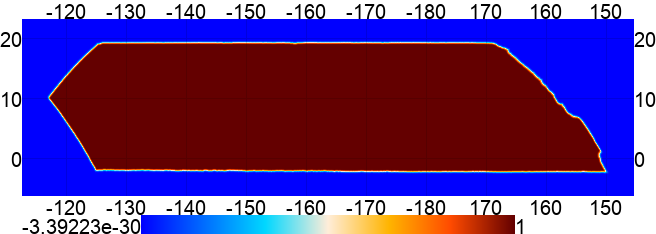

In [7]:
kwargs = {'ticks':10,'colorbar':True}
plots = enplot.plot(W2d,**kwargs)
enplot.show(plots, method = 'ipython')

In [8]:
sn = 500
ol = np.zeros((sn,bnum))
for i in tqdm.tqdm(range(sn)):
    Talm = cs.utils.gauss1alm(lmax,lcl[0,:])
    Tmap = cs.utils.hp_alm2map(nside,lmax,lmax,Talm)
    T2d = reproject.enmap_from_healpix(Tmap, oshape, WCS, rot=None)[0] * W2d
    ny, nx = np.shape(T2d)
    Tlm2d = fs.ffttools.dft2d(T2d.T,nx,ny,D,1)
    ol[i] = fs.utils.alm2bcl(bnum,[1,lmax],nx,ny,D,Tlm2d)

100%|██████████| 500/500 [12:54<00:00,  1.55s/it]


In [9]:
mcl = np.mean(ol,axis=0)
vcl = np.std(ol,axis=0)

In [10]:
mb = bn.multipole_binning(bnum,lmin=1,lmax=lmax)
print(mb.bc)

[ 13.775  39.325  64.875  90.425 115.975 141.525 167.075 192.625 218.175
 243.725 269.275 294.825 320.375 345.925 371.475 397.025 422.575 448.125
 473.675 499.225]


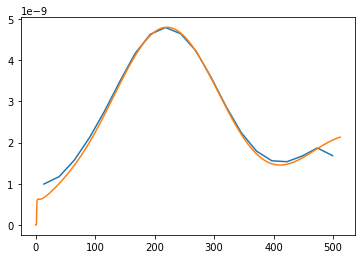

In [11]:
#pl.plot_1dstyle(fsize=[7,4],xmin=2,xmax=lmax,ymin=1e-10,ymax=8e-9,ylog=True)
plot(mb.bc,mb.bc**2*mcl/W2)
plot(l,l**2*lcl[0])

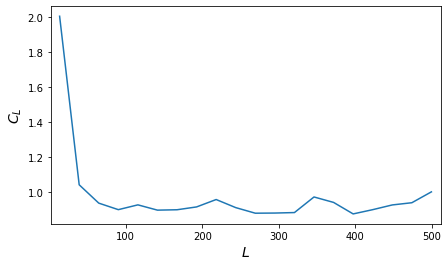

In [12]:
pl.plot_1dstyle(fsize=[7,4],xmin=2,xmax=lmax)
plot(mb.bc,vcl/mcl*np.sqrt((mb.bc+0.5)*lmax/bnum*fsky*Fsky))

In [13]:
itt     = np.zeros(lmax+1)
iee     = np.zeros(lmax+1)
ibb     = np.zeros(lmax+1)
itt[2:] = 1./lcl[0,2:]
iee[2:] = 1./lcl[1,2:]
ibb[2:] = 1./lcl[2,2:]
# assign 1d cl on 2d grind
cltt = fs.utils.cl2c2d(nx,ny,D,2,lmax,lcl[0,:])
clee = fs.utils.cl2c2d(nx,ny,D,2,lmax,lcl[1,:])
clte = fs.utils.cl2c2d(nx,ny,D,2,lmax,lcl[3,:])
iltt = fs.utils.cl2c2d(nx,ny,D,2,lmax,itt)
ilee = fs.utils.cl2c2d(nx,ny,D,2,lmax,iee)
ilbb = fs.utils.cl2c2d(nx,ny,D,2,lmax,ibb)

In [ ]:
# compute analytic normalization with 2d filtering
rL = [2,lmax]
oL = [2,lmax]
Ag, Ac = {}, {}
Ag['TT'], Ac['TT'] = fs.norm_lens.qtt(nx,ny,D,rL,iltt,cltt,oL)
Ag['TE'], Ac['TE'] = fs.norm_lens.qte(nx,ny,D,rL,iltt,ilee,clte,oL)
Ag['TB'], Ac['TB'] = fs.norm_lens.qtb(nx,ny,D,iltt,ilbb,clte,rL,oL)
Ag['EE'], Ac['EE'] = fs.norm_lens.qee(nx,ny,D,ilee,clee,rL,oL)
Ag['EB'], Ac['EB'] = fs.norm_lens.qeb(nx,ny,D,ilee,ilbb,clee,rL,oL)